In [70]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train


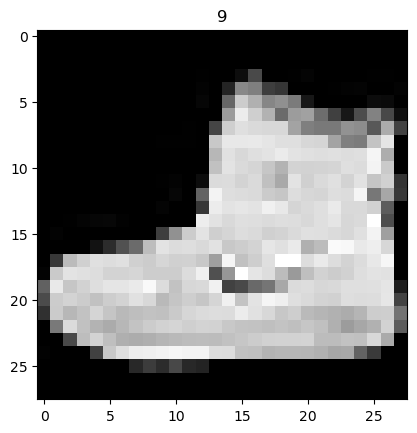

In [71]:
# Load and see MNIST data
train_data = datasets.FashionMNIST(root='./data', train=True, download=True)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True)

# See dataset
print(train_data)

img, label = train_data[0]
plt.imshow(img, cmap='gray')
plt.title(label)
plt.show()


img.shape: torch.Size([1, 28, 28])


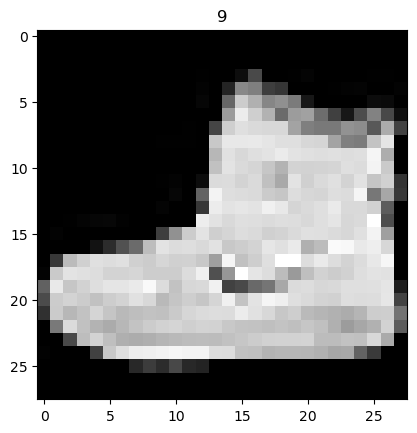

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL ImageまたはNumPy ndarrayをPyTorchのテンソルに変換
    transforms.Normalize((0.5,), (0.5,))  # 画像の正規化（オプショナル）
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

img, label = train_data[0]
img: torch.Tensor
label: int

print(f"img.shape: {img.shape}")

# img = img.squeeze() # matplotlibで画像は `[高さ, 幅, (チャンネル数)]` なので、グレースケールを表示するには squeeze でチャンネル数を削除するのが簡単
# print(f"img.shape: {img.shape} # squeezed")
# plt.imshow(img, cmap='gray')

img = img.permute(1, 2, 0)  # チャンネル数を一番後ろに
plt.imshow(img, cmap='gray')

plt.title(label)
plt.show()

In [73]:
# Define model
class CNNModel(torch.nn.Module):
    def __init__(self, x_size):
        super().__init__()

        in_channels = 1 # gray scale
        out_channels_1 = 16 # number of filters
        out_channels_2 = 32
        kernel_size = 3 # size of filter

        # kernel_size = 3 だと、畳み込みで各方向に2ピクセル分の次元が縮小される。
        # 入力と出力の次元を揃えることで、深い層でも出力サイズの暗算が楽になる。
        padding = 1

        pool_size = 2

        # 2回のプーリングで、縦横ともに1/4になる。
        self.fc_input_size = (x_size // (pool_size ** 2)) ** 2 * out_channels_2
        print(f"fc_input_size: {self.fc_input_size}")

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels_1, kernel_size, padding=1)
        self.conv2 = torch.nn.Conv2d(out_channels_1, out_channels_2, kernel_size, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(pool_size)
        self.fc = torch.nn.Linear(self.fc_input_size, 10)

    def forward(self, x):
        h1 = self.pool(self.relu(self.conv1(x)))
        h2 = self.pool(self.relu(self.conv2(h1)))
        out = self.fc(h2.view(-1, self.fc_input_size))
        return out


In [74]:
def to_device(x):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    return x.to(device)

fc_input_size: 1568
epoch: 0, loss: 0.396, acc: 0.858
epoch: 1, loss: 0.338, acc: 0.879
epoch: 2, loss: 0.312, acc: 0.889
epoch: 3, loss: 0.291, acc: 0.897
epoch: 4, loss: 0.297, acc: 0.894
epoch: 5, loss: 0.277, acc: 0.902
epoch: 6, loss: 0.277, acc: 0.904
epoch: 7, loss: 0.279, acc: 0.901
epoch: 8, loss: 0.268, acc: 0.906
epoch: 9, loss: 0.258, acc: 0.91


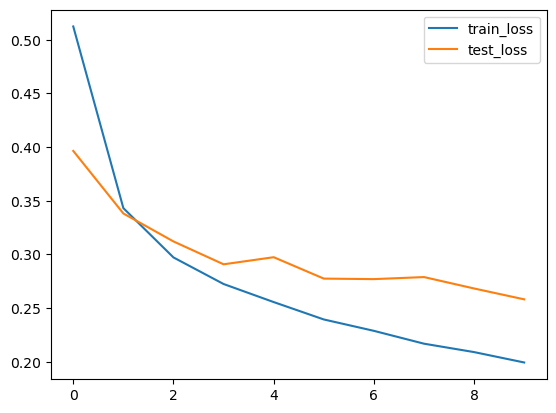

In [75]:
# Train
image_index, image, channel = 0, 0, 0
model = CNNModel(x_size = len(train_data[image_index][image][channel]))

if torch.cuda.is_available():
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
}

for epoch in range(epochs):
    # Train
    model.train()
    train_loss = 0
    for x, t in train_loader:
        x, t = to_device(x), to_device(t)
        y = model(x)
        loss = torch.nn.functional.cross_entropy(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    history['train_loss'].append(train_loss / len(train_loader))

    # Test
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for x, t in test_loader:
            x, t = to_device(x), to_device(t)
            y = model(x)
            loss = torch.nn.functional.cross_entropy(y, t)
            test_loss += loss.item()
            test_acc += (y.max(1)[1] == t).sum().item()
    history['test_loss'].append(test_loss / len(test_loader))
    history['test_acc'].append(test_acc / len(test_loader.dataset))

    print('epoch: {}, loss: {:.3}, acc: {:.3}'.format(epoch, history['test_loss'][-1], history['test_acc'][-1]))

# Plot
plt.plot(range(epochs), history['train_loss'], label='train_loss')
plt.plot(range(epochs), history['test_loss'], label='test_loss')
plt.legend()
plt.show()


In [76]:
# Classify my own image